In [1]:
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import get_ipython
from IPython import display
import torch
import random
import re
import collections
import inspect
import os
import hashlib # Added missing import
import zipfile # Added missing import
import tarfile # Added missing import
import requests # Import the requests library
from torch import nn
from torch.nn import functional as F

In [2]:

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def plot(X,Y=None,xlabel=None, ylabel=None, legend=[],xlim=None, ylim=None, xscale='linear',yscale='linear',fmts=('-','m--','g-.','r:'),figsize=(3.5,2.5),axes=None):
    def has_one_axis(X):
        return(hasattr(X,'ndim') and X.ndim == 1 or isinstance(X,list) and not hasattr(X[0],"__len__"))
    if has_one_axis(X): X=[X]
    if Y is None:
        X,Y=[[]]*len(X),X
    elif has_one_axis(Y):
        Y=[Y]
    if len(X) != len(Y):
        X=X*len(Y)
    set_figsize(figsize)
    if axes is None:
        axes=plt.gca()
    axes.cla()
    for x,y,fmt in zip (X,Y,fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend)

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.

        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)


In [3]:
class Module(nn.Module, HyperParameters):
    def __init__(self,plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board= ProgressBoard()
    def squared_loss(self,y_hat,y):
        return(y_hat-y.reshape(y_hat.shape))**2/2
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural Network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        assert hasattr(self,'trainer'), 'Trainer is not inited'
        self.board.xlabel='epoch'
        if train:
            x= self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n=self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x=self.trainer.epoch+1
            n=self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        if isinstance(value, int):
            value=torch.tensor(value)
        self.board.draw(x,value.to('cpu').detach().numpy(), ('train_' if train else 'val_')+key, every_n=int(n))

    def training_step(self, batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self,batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=self.lr)
    def  apply_init(self, inputs, init=None):
        self.forward(inputs)
        if init is not None:
            self.net.apply(init)

In [4]:
class DataModule(HyperParameters):
    def __init__(self, root='./data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self,train):
        i=slice(0,self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)


In [5]:
def gpu(i=0):
    return torch.device(f'cuda:{i}')
def num_gpus():
    return torch.cuda.device_count()
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus_arg=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus=[gpu(i) for i in range(min(num_gpus_arg, num_gpus()))]
    def prepare_data(self,data):
        self.train_dataloader=data.train_dataloader()
        self.val_dataloader=data.val_dataloader()
        self.num_train_batches=len(self.train_dataloader)
        self.num_val_batches=(len(self.val_dataloader) if self.val_dataloader is not None else 0)
    def prepare_model(self,model):
        model.trainer=self
        model.board.xlim=[0,self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model=model
    def fit(self,model,data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim=model.configure_optimizers()
        self.epoch=0
        self.train_batch_idx=0
        self.val_batch_idx=0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0: # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    def prepare_batch(self,batch):
        if self.gpus:
            batch=[a.to(self.gpus[0]) for a in batch]
        return batch
    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm



In [6]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
    def accuracy(Self, Y_hat, Y, averaged=True):
        Y_hat= Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds=Y_hat.argmax(axis=1).type(Y.dtype)
        compare=(preds==Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    def layer_summary(self,X_shape):
        X=torch.randn(*X_shape)
        for layer in self.net:
            X=layer(X)
            print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [7]:
def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    if not url.startswith('http'):
    # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
            sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def extract(filename, folder=None):
    """Extract a zip/tar file into folder."""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

In [8]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [9]:
class Vocab:
  def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
    if tokens and isinstance(tokens[0],list):
      tokens=[token for line in tokens for token in line]
    counter=collections.Counter(tokens)
    self.token_freqs=sorted(counter.items(), key=lambda x:x[1], reverse=True)
    self.idx_to_token=list(sorted(set(['<unk>']+reserved_tokens+[token for token, freq in self.token_freqs if freq>=min_freq])))
    self.token_to_idx={token:idx for idx, token in enumerate(self.idx_to_token)}
  def __len__(self):
    return len(self.idx_to_token)
  def __getitem__(self,tokens):
    if not isinstance(tokens,(list,tuple)):
      return self.token_to_idx.get(tokens,self.unk)
    return [self.__getitem__(token) for token in tokens]
  def to_tokens(self, indices):
    if hasattr(indices,'__len__') and len(indices)>1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]
  @property
  def unk(self):
    return self.token_to_idx['<unk>']

In [10]:
class MTFraEng(DataModule):
  def _download(self):
    extract(download(DATA_URL + 'fra-eng.zip', self.root, '94646ad1522d915e7b0f9296181140edcf86a4f5' ))
    with open(self.root+'/fra-eng/fra.txt', encoding='utf-8') as f:
      return f.read()
  def _preprocess(self, text):
    text=text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space=lambda char, prev_char: char in ',.!?' and prev_char!=' '
    out=[' ' if i>0 and no_space(char, text[i-1]) else char for i,char in enumerate(text.lower())]
    return ''.join(out)
  def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples:
            break
        parts=line.split('\t')
        if len(parts)==2:
          src.append([t for t in f'{parts[0]}<eos>'.split(' ') if t])
          tgt.append([t for t in f'{parts[1]}<eos>'.split(' ') if t])
    return src, tgt
  def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())
  def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len= (array!=vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)
  def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)
  def build(self, src_sentences, tgt_sentences):
    raw_text='\n'.join([src+'\t'+ tgt for src, tgt in zip(src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

In [11]:
class Encoder(nn.Module):
    def __init__(self):
      super().__init__()
    def forward(self, X, *args):
      raise NotImplemented
class Decoder(nn.Module):
    def __init__(self):
      super().__init__()
    def init_state(self, enc_outputs, *args):
      raise NotImplemented
    def forward(self, X, state):
      raise NotImplemented
class EncoderDecoder(Classifier):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
  def forward(self, enc_X, dec_X, *args):
    enc_all_outputs=self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_all_outputs, *args)
    return self.decoder(dec_X, dec_state)[0]
  def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch=[a.to(device) for a in batch]
    src, tgt, src_valid_len, _= batch
    self.encoder.to(device)
    self.decoder.to(device)
    enc_all_outputs=self.encoder(src, src_valid_len)
    dec_state=self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1)], []
    for _ in range(num_steps):
      Y, dec_state = self.decoder(outputs[-1], dec_state)
      outputs.append(Y.argmax(dim=2))
      if save_attention_weights:
        attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], dim=1), attention_weights

In [12]:
def init_seq2seq(module):
  if type(module)==nn.Linear:
    nn.init.xavier_uniform_(module.weight)
  if type(module) == nn.GRU:
    for param in module._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(module._parameters[param])

In [13]:
class RNN(Module):
  def __init__(self, num_inputs, num_hiddens):
    super().__init__()
    self.save_hyperparameters()
    self.rnn=nn.RNN(num_inputs, num_hiddens)
  def forward(self, inputs, H=None):
    return self.rnn(inputs, H)
class GRU(RNN):
  def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
    Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
    dropout=dropout)


In [14]:
class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size, embed_size)
    self.rnn=GRU(embed_size, num_hiddens, num_layers, dropout)
    self.apply(init_seq2seq)
  def forward(self, X, *args):
    embs=self.embedding(X.t().type(torch.int64))
    outputs, state=self.rnn(embs)
    return outputs, state


In [15]:
class Seq2SeqDecoder(Decoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size, embed_size)
    self.rnn=GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
    self.dense=nn.LazyLinear(vocab_size)
    self.apply(init_seq2seq)
  def init_state(self, enc_all_outputs, *args):
    return enc_all_outputs
  def forward(self, X, state):
    embs=self.embedding(X.t().type(torch.int32))
    enc_output, hidden_state =state
    context=enc_output[-1]
    context=context.repeat(embs.shape[0], 1,1)
    embs_and_context=torch.cat((embs, context), 2)
    output, hidden_state=self.rnn(embs_and_context, hidden_state)
    output=self.dense(output).swapaxes(0,1)
    return output, [enc_output, hidden_state]


In [16]:
class Seq2Seq(EncoderDecoder):
  def __init__(self, encoder, decoder, tgt_pad, lr):
    super().__init__(encoder, decoder)
    self.save_hyperparameters()
  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)
  def loss(self, Y_hat, Y):
    Y_hat = Y_hat.reshape(-1, Y_hat.shape[-1])
    Y = Y.reshape(-1)
    l = F.cross_entropy(Y_hat, Y, reduction='none')
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return l.sum()/mask.sum()

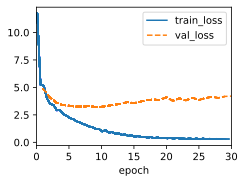

In [17]:
data=MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder=Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder=Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model=Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer=Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [18]:
def predict_step(self, batch, device, num_steps,save_attention_weights=False):
  batch = [a.to(device) for a in batch]
  src, tgt, src_valid_len, _ = batch
  enc_all_outputs = self.encoder(src, src_valid_len)
  dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
  outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
  for _ in range(num_steps):
    Y, dec_state = self.decoder(outputs[-1], dec_state)
    outputs.append(Y.argmax(2))
    if save_attention_weights:
      attention_weights.append(self.decoder.attention_weights)
  return torch.cat(outputs[1:], 1), attention_weights

In [19]:
import math

In [20]:
def bleu(pred_seq, label_seq, k):
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, min(k, len_pred)+1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
      label_subs[''.join(label_tokens[i: i +n])] += 1
    for i in range(len_pred - n + 1):
      if label_subs[''.join(pred_tokens[i: i + n])] > 0:
        num_matches += 1
        label_subs[''.join(pred_tokens[i: i + n])] -= 1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
  return score

In [21]:
def cpu():
  """Get the CPU device."""
  return torch.device('cpu')
def try_gpu(i=0):
  if num_gpus() >= i + 1:
    return gpu(i)
  return cpu()

In [22]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
  translation = []
  for token in data.tgt_vocab.to_tokens(p):
    if token == '<eos>':
      break
    translation.append(token)
  print(f'{en} => {translation}, bleu,'f'{bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['<unk>'], bleu,0.000
i lost . => ["j'ai", '<unk>'], bleu,0.000
he's calm . => ['il', 'est', '<unk>'], bleu,0.492
i'm home . => ['je', 'suis', '<unk>'], bleu,0.353
